In [1]:
!pip install hampel

In [2]:
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from hampel import hampel
from IPython.display import clear_output
import time
import math
from sklearn.metrics import mean_squared_error
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [3]:
df = pd.read_csv('../input/medidascpd1/quarterly_measurements_CPD1.csv')
df['collection_date'] = pd.to_datetime(df['collection_date'], format='%Y-%m-%d %H:%M:%S')
df = df.sort_values('collection_date')
df

,id,collection_date,transductor_id,generated_energy_peak_time,generated_energy_off_peak_time,consumption_peak_time,consumption_off_peak_time,inductive_power_peak_time,inductive_power_off_peak_time,capacitive_power_peak_time,capacitive_power_off_peak_time,tax_id
0,1,2020-09-16 16:15:00,1,0.0,2236.937256,0.0,5788.039551,0.0,3774.395508,0.0,3343.380127,NaN
1,2,2020-09-16 16:15:00,1,0.0,2236.937256,0.0,5788.039551,0.0,3774.395508,0.0,3343.380127,NaN
2,3,2020-09-16 16:30:00,1,0.0,2251.918701,0.0,5816.766602,0.0,3787.614746,0.0,3350.856689,NaN
3,4,2020-09-16 16:45:00,1,0.0,2245.714600,0.0,5757.487793,0.0,3746.929932,0.0,3330.228760,NaN
4,5,2020-09-16 17:00:00,1,0.0,2212.775146,0.0,5719.126953,0.0,3702.991455,0.0,3304.887939,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
19370,113879,2021-05-04 07:30:00,1,0.0,1463.972778,0.0,4005.716553,0.0,2393.689453,0.0,2157.177002,NaN
19371,113880,2021-05-04 07:45:00,1,0.0,1453.804810,0.0,3977.073242,0.0,2424.012939,0.0,2201.976562,NaN
19372,113881,2021-05-04 08:00:00,1,0.0,1513.270142,0.0,4008.998291,0.0,2393.126221,0.0,2318.023926,NaN
19373,113882,2021-05-04 08:15:00,1,0.0,1528.613159,0.0,4209.576172,0.0,2475.284668,0.0,2283.731445,NaN


In [4]:
df.dtypes

id                                         int64
collection_date                   datetime64[ns]
transductor_id                             int64
generated_energy_peak_time               float64
generated_energy_off_peak_time           float64
consumption_peak_time                    float64
consumption_off_peak_time                float64
inductive_power_peak_time                float64
inductive_power_off_peak_time            float64
capacitive_power_peak_time               float64
capacitive_power_off_peak_time           float64
tax_id                                   float64
dtype: object

In [5]:
df['Consumo'] = df['generated_energy_peak_time'] + df['generated_energy_off_peak_time'] + df['consumption_peak_time'] + df['consumption_off_peak_time']

In [6]:
no_outliers_consumption = hampel(df['Consumo'], window_size=16, n=2, imputation=True)

In [7]:
df['no_outliers_consumption'] = no_outliers_consumption

In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

data = df[['no_outliers_consumption']]
scaler.fit(data)
data = scaler.transform(data)
data = pd.DataFrame({'no_outliers_consumption': data.flatten()})

n = len(df)
train_df = data[0:int(n*0.7)][["no_outliers_consumption"]]
test_df = data[int(n*0.7):][["no_outliers_consumption"]]

In [9]:
from keras.preprocessing.sequence import TimeseriesGenerator

look_back = 96

train_generator = TimeseriesGenerator(train_df['no_outliers_consumption'].values, train_df['no_outliers_consumption'].values, length=look_back, batch_size=1)     
test_generator = TimeseriesGenerator(test_df['no_outliers_consumption'].values, test_df['no_outliers_consumption'].values, length=look_back, batch_size=1)

In [10]:
X_train = np.array([data[0][0] for data in train_generator]).reshape((13466, 96, 1))
y_train = np.array([data[1] for data in train_generator]).reshape((13466, 1, 1))

X_test = np.array([data[0][0] for data in test_generator]).reshape((5717, 96, 1))
y_test = np.array([data[1] for data in test_generator]).reshape((5717, 1, 1))



In [11]:
MAX_EPOCHS = 15

# def compile_and_fit(model, window, patience=2):
# #   early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
# #                                                     patience=patience,
# #                                                     mode='min')
tf.keras.backend.clear_session()

model = tf.keras.Sequential([
    tf.keras.Input(shape=(96,1,), dtype='float32', name='input'),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(units=1)
])

model.compile(loss=tf.losses.MeanSquaredError(),
            optimizer=tf.optimizers.Adam(),
            metrics=[tf.metrics.MeanAbsoluteError()])

start = time.time()
history = model.fit(X_train, y_train, epochs=MAX_EPOCHS)
end = time.time()

Epoch 1/15
421/421 [==============================] - 11s 14ms/step - loss: 0.0220 - mean_absolute_error: 0.0702
Epoch 2/15
421/421 [==============================] - 6s 13ms/step - loss: 0.0011 - mean_absolute_error: 0.0185
Epoch 3/15
421/421 [==============================] - 6s 13ms/step - loss: 6.0593e-04 - mean_absolute_error: 0.0146
Epoch 4/15
421/421 [==============================] - 6s 14ms/step - loss: 8.7025e-04 - mean_absolute_error: 0.0176
Epoch 5/15
421/421 [==============================] - 6s 13ms/step - loss: 5.6430e-04 - mean_absolute_error: 0.0144
Epoch 6/15
421/421 [==============================] - 6s 13ms/step - loss: 4.5966e-04 - mean_absolute_error: 0.0134
Epoch 7/15
421/421 [==============================] - 6s 14ms/step - loss: 6.3472e-04 - mean_absolute_error: 0.0139
Epoch 8/15
421/421 [==============================] - 5s 13ms/step - loss: 6.4967e-04 - mean_absolute_error: 0.0151
Epoch 9/15
421/421 [==============================] - 6s 13ms/step - loss: 5.11

In [12]:
print(f"Initial training time: {end-start} s")

Initial training time: 90.59124445915222 s


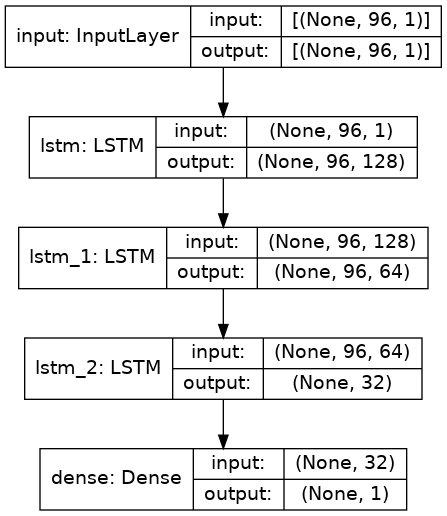

In [13]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [14]:
preds = []
obs = []

In [15]:
start_forecasting = time.time()

for i in range(len(X_test)):
    if i < len(X_test) - 1:

        model.fit(X_test[i].reshape((1, 96, 1)), y_test[i].reshape((1, 1, 1)),
                 verbose=0 )

        output = model.predict(X_test[i+1].reshape((1,96,1)))

        preds.append(output[0][0])
        print(i)
        clear_output(wait=True)

end_forecasting = time.time()

5715


In [16]:
print(f"Rolling forecasting time: {end_forecasting-start_forecasting} s")
print(f"Total training time: {(end-start) + (end_forecasting-start_forecasting)} s")

Rolling forecasting time: 517.736475944519 s
Total training time: 608.3277204036713 s


In [17]:
_preds_inv = scaler.inverse_transform([preds])
obs_inv = scaler.inverse_transform([y_test.reshape((5717))])

In [18]:
size = len(df) - len(obs_inv[0]) + 1

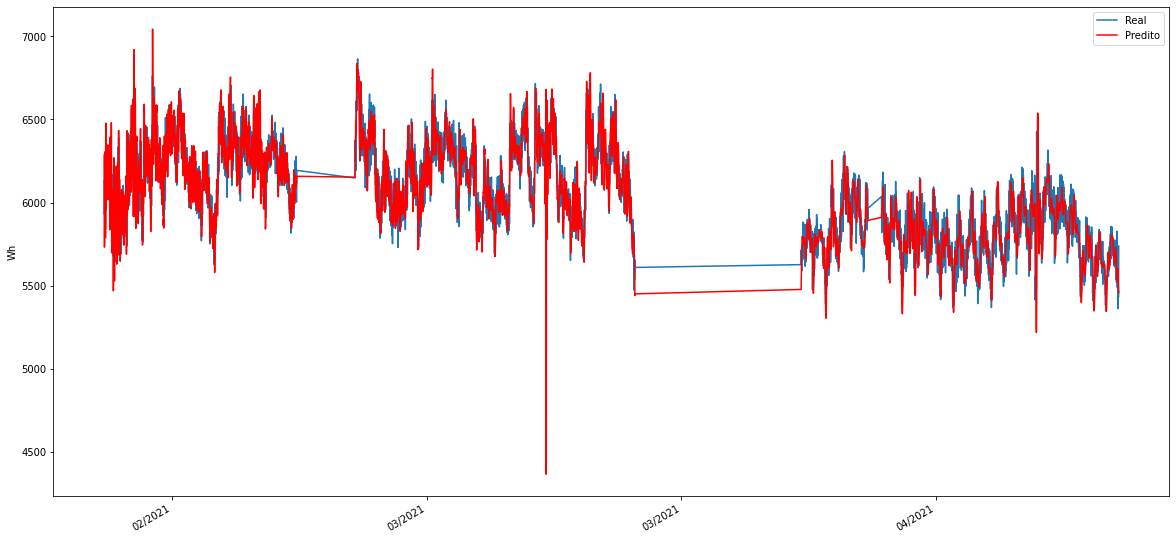

<Figure size 576x432 with 0 Axes>

In [19]:
import matplotlib.dates as mdates

plt.figure(figsize=(20,10))
plt.ylabel('Wh')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=20))
plt.gcf().autofmt_xdate()

# plt.title('Predições para os próximos 15 min.')
plt.plot(df[size:].collection_date, obs_inv[0][:-1], label='Real')
plt.plot(df[size:].collection_date, _preds_inv[0], color='red', label='Predito')
plt.legend(loc="upper right")
plt.show()
plt.savefig('lstm.png')


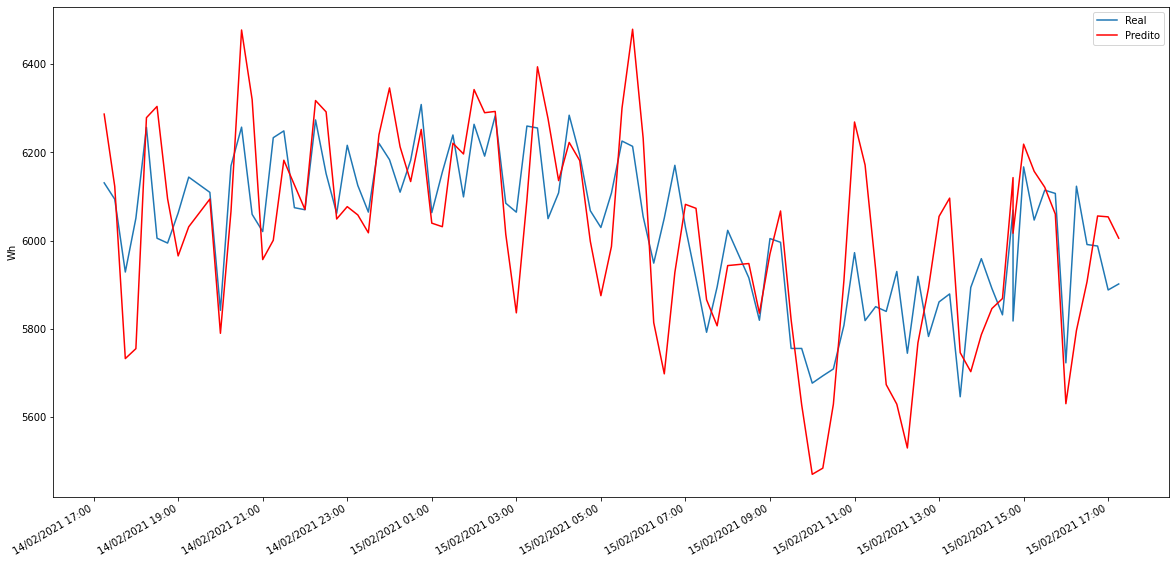

In [20]:

plt.figure(figsize=(20,10))
plt.ylabel('Wh')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval = 2))
plt.gcf().autofmt_xdate()


plt.plot(df[size + 96:size+96+96].collection_date, obs_inv[0][:96], label='Real')
plt.plot(df[size + 96:size+96+96].collection_date, _preds_inv[0][:96], color='red', label='Predito')
plt.legend(loc="upper right")
plt.show()

In [21]:
from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(obs_inv[0][:-1], _preds_inv[0]))

86.79490726480674


In [22]:
model.save('model.json')